In [1]:
# Needed to switch directory in Google drive so as to import CDA env.
from google.colab import drive 
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/"
!pwd
!pip install -r requirements.txt
!pip show tensorflow
!pip show ray

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction
Obtaining gym_continuousDoubleAuction from git+https://github.com/ChuaCheowHuan/gym-continuousDoubleAuction.git@c897137cbcc93ca71cbd51c27e683c3298f6562d#egg=gym_continuousDoubleAuction (from -r requirements.txt (line 24))
  Skipping because already up-to-date.
  Found existing installation: gym-continuousDoubleAuction 0.0.1
    Can't uninstall 'gym-continuousDoubleAuction'. No files were found to uninstall.
  Running setup.py develop for gym-continuousDoubleAuction
Name: tensorflow
Version: 2.1.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
os.environ['RAY_DEBUG_DISABLE_MEMORY_MONITOR'] = "True"

import argparse
import gym
import random
import numpy as np

import ray
from ray import tune
from ray.rllib.utils import try_import_tf
from ray.tune.registry import register_env
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.models.tf.fcnet_v2 import FullyConnectedNetwork
from ray.rllib.models import Model, ModelCatalog
from ray.rllib.policy.policy import Policy
from ray.rllib.agents.ppo import ppo
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.rllib.agents.ppo.ppo_tf_policy import PPOTFPolicy
from ray.tune.logger import pretty_print

import sys
if "../" not in sys.path:
    sys.path.append("../")

from gym_continuousDoubleAuction.envs.continuousDoubleAuction_env import continuousDoubleAuctionEnv

tf = try_import_tf()

In [0]:
class CustomModel_1(Model):
    """
    Sample custom model with LSTM. 
    """

    def _lstm(self, Inputs, cell_size):
        s = tf.expand_dims(Inputs, axis=1, name='time_major')  # [time_step, feature] => [time_step, batch, feature]
        lstm_cell = tf.nn.rnn_cell.LSTMCell(cell_size)
        self.init_state = lstm_cell.zero_state(batch_size=1, dtype=tf.float32)
        # time_major means [time_step, batch, feature] while batch major means [batch, time_step, feature]
        outputs, self.final_state = tf.nn.dynamic_rnn(cell=lstm_cell, inputs=s, initial_state=self.init_state, time_major=True)
        lstm_out = tf.reshape(outputs, [-1, cell_size], name='flatten_rnn_outputs')  # joined state representation
        return lstm_out
    
    def _build_layers_v2(self, input_dict, num_outputs, options):
        hidden = 512
        cell_size = 256
        #S = input_dict["obs"]
        S = tf.layers.flatten(input_dict["obs"])
        with tf.variable_scope(tf.VariableScope(tf.AUTO_REUSE, "shared"),
                               reuse=tf.AUTO_REUSE,
                               auxiliary_name_scope=False):
            last_layer = tf.layers.dense(S, hidden, activation=tf.nn.relu, name="fc1")
        last_layer = tf.layers.dense(last_layer, hidden, activation=tf.nn.relu, name="fc2")
        last_layer = tf.layers.dense(last_layer, hidden, activation=tf.nn.relu, name="fc3")

        last_layer = self._lstm(last_layer, cell_size)

        output = tf.layers.dense(last_layer, num_outputs, activation=tf.nn.softmax, name="mu")

        return output, last_layer

In [0]:
def make_RandomPolicy(_seed):

    class RandomPolicy(Policy):
        """
        A hand-coded policy that returns random actions in the env (doesn't learn).
        """        
        
        def __init__(self, observation_space, action_space, config):
            self.observation_space = observation_space
            self.action_space = action_space
            self.action_space.seed(_seed)

        def compute_actions(self,
                            obs_batch,
                            state_batches,
                            prev_action_batch=None,
                            prev_reward_batch=None,
                            info_batch=None,
                            episodes=None,
                            **kwargs):
            """Compute actions on a batch of observations."""
            return [self.action_space.sample() for _ in obs_batch], [], {}

        def learn_on_batch(self, samples):
            """No learning."""
            #return {}
            pass

        def get_weights(self):
            pass

        def set_weights(self, weights):
            pass

    return RandomPolicy

In [5]:
# global

# CDA_env args
num_agents = 4
num_trained_agent = 2 # 1st 2
num_policies = num_agents # Each agent is using a separate policy
num_of_traders = num_agents
tape_display_length = 10 
tick_size = 1
init_cash = 1000000
max_step = 1000 # per episode, -1 in arg.
is_render = False

# Storage for on_train_result callback, use for plotting.
def create_storage(msg, msg2):
    storage = {}
    for i in range(0, num_agents):
        storage[msg + str(i) + msg2] = []  
    return storage

reward_store = create_storage("agt_", "_reward_list")
NAV_store = create_storage("agt_", "_NAV_list")


# RLlib config
num_workers = 1
num_envs_per_worker = 2
sample_batch_size = 32
train_batch_size = 128
num_iters = 150

# Chkpt & restore
local_dir="/content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/"
chkpt_freq = 10
chkpt = 450
restore_path = "{}checkpoint_{}/checkpoint-{}".format(local_dir, chkpt, chkpt)
is_restore = True

# get obs & act spaces from dummy CDA env
single_CDA_env = continuousDoubleAuctionEnv(num_of_traders, init_cash, tick_size, tape_display_length, max_step, is_render)
obs_space = single_CDA_env.observation_space
act_space = single_CDA_env.action_space

# register CDA env with RLlib 
register_env("continuousDoubleAuction-v0", lambda _: continuousDoubleAuctionEnv(num_of_traders, 
                                                                                init_cash, 
                                                                                tick_size, 
                                                                                tape_display_length,
                                                                                max_step-1, 
                                                                                is_render))

# register custom model (neural network)
ModelCatalog.register_custom_model("model_disc", CustomModel_1) 

# start ray
ray.init(ignore_reinit_error=True, log_to_driver=True, webui_host='127.0.0.1', num_cpus=2) 

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-03-26 10:44:17,597	WARNING services.py:586 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-03-26 10:44:17,600	INFO resource_spec.py:212 -- Starting Ray with 6.69 GiB memory available for workers and up to 3.36 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-03-26 10:44:18,128	INFO services.py:1078 -- View the Ray dashboard at 127.0.0.1:8265


{'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2020-03-26_10-44-17_596466_12083/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-03-26_10-44-17_596466_12083/sockets/raylet',
 'redis_address': '172.28.0.2:45774',
 'session_dir': '/tmp/ray/session_2020-03-26_10-44-17_596466_12083',
 'webui_url': '127.0.0.1:8265'}

In [6]:
# Policies

def gen_policy(i):
    """
    Each policy can have a different configuration (including custom model)
    """
    config = {"model": {"custom_model": "model_disc"},
              "gamma": 0.99,}
    return (None, obs_space, act_space, config)

def policy_mapper(agent_id):
    for i in range(num_agents):
        if agent_id == i:
            return "policy_{}".format(i)


# Dictionary of policies
policies = {"policy_{}".format(i): gen_policy(i) for i in range(num_policies)}


def set_agents_policies(policies):
    """
    Set 1st policy as PPO & override all other policies as RandomPolicy with
    different seed.
    """
    
    # set all agents to use random policy
    for i in range(num_agents):
        policies["policy_{}".format(i)] = (make_RandomPolicy(i), obs_space, act_space, {})
    
    # set agent 0 & 1 to use None (PPOTFPolicy)
    offset = 2 # num of trained agents
    for i in range(num_agents-offset):
        #policies["policy_{}".format(i)] = (PPOTFPolicy, obs_space, act_space, {})
        policies["policy_{}".format(i)] = (None, obs_space, act_space, {})

    print('policies:', policies)
    return 0


set_agents_policies(policies)
policy_ids = list(policies.keys())

policies: {'policy_0': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_1': (None, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_2': (<class '__main__.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {}), 'policy_3': (<class '__main__.make_RandomPolicy.<locals>.RandomPolicy'>, Box(4, 10), Tuple(Discrete(3), Discrete(4), Box(1,), Box(1,), Discrete(12)), {})}


In [0]:
def on_episode_start(info):
    """
    info["episode"] is a MultiAgentEpisode object.
    """

    episode = info["episode"] 
    print("episode {} started".format(episode.episode_id))

    # hist_data dicts at 100 items max, will auto replace old with new item at 1st index.      
    for i in range(num_agents):
        key = "agt_" + str(i) + "_NAV"
        episode.hist_data[key] = []      

In [0]:
def on_episode_end(info):
    """
    arg: {"env": .., "episode": ...}
    """

    episode = info["episode"]
    print("on_episode_end episode_id={}, length={}".format(episode.episode_id, episode.length))       

    for i in range(num_agents):
        key = "agt_" + str(i) + "_NAV"
        episode.hist_data[key].append(episode.last_info_for(i)["NAV"])   


In [0]:
def get_trained_policies_name():
    """
    Get index of the max reward of the trained policies in most recent episode.
    """
    train_policies_name = []
    i = 0
    for k,v in policies.items():
        if i < num_trained_agent:
            train_policies_name.append(k)
        i = i + 1
    return train_policies_name

In [0]:
def get_max_reward_ind(info, train_policies_name):
    """
    Get index of the max reward of the trained policies in most recent episode.
    """    

    recent_policies_rewards = []
    for i in train_policies_name:
        key = 'policy_' + str(i) + '_reward'
        v = info['result']['hist_stats'][key]
        recent_policies_rewards.append(v[0])

    max_reward_ind = np.argmax(recent_policies_rewards)
    return max_reward_ind         

In [0]:
def _cp_weight(trainer, src, dest):
    """
    Copy weights of source policy to destination policy.
    """
    
    P0key_P1val = {}
    for (k,v), (k2,v2) in zip(trainer.get_policy(dest).get_weights().items(), 
                              trainer.get_policy(src).get_weights().items()):            
        P0key_P1val[k] = v2

    trainer.set_weights({dest:P0key_P1val, 
                         src:trainer.get_policy(src).get_weights()})

    for (k,v), (k2,v2) in zip(trainer.get_policy(dest).get_weights().items(), 
                              trainer.get_policy(src).get_weights().items()):            
        assert (v == v2).all()    

In [0]:
def cp_weight(trainer, train_policies_name, max_reward_policy_name):
    """
    Copy weights of winning policy to weights of other trained policies.
    Winning is defined as getting max reward in the current episode.
    """

    for name in train_policies_name:
        if name != max_reward_policy_name:
            _cp_weight(trainer, max_reward_policy_name, name)   

In [0]:
def all_eps_store(info, store, msg, msg2, msg3):
    i = 0
    print("store", store)
    for k,v in store.items():
        name = msg + str(i) + msg2
        v.append(info["result"]["hist_stats"][name][0])
        p_str = msg + str(i) + msg3
        print(p_str.format(v[0])) 
        i = i + 1                      

In [0]:
def on_train_result(info):
    """
    info["trainer"] is the trainer object.

    info["result"] contains a bunch of info such as episodic rewards 
    for each policy in info["result"][hist_stats] dictionary.
    """

    # you can mutate the result dict to add new fields to return
    info["result"]["callback_ok"] = True
    
    train_policies_name = get_trained_policies_name()    
    max_reward_ind = get_max_reward_ind(info, train_policies_name)
    max_reward_policy_name = train_policies_name[max_reward_ind]
    cp_weight(info["trainer"], train_policies_name, max_reward_policy_name)    

    all_eps_store(info, reward_store, "policy_policy_", "_reward", "_reward_list[0] = {}") 
    all_eps_store(info, NAV_store, "agt_", "_NAV", "_NAV_list[0] = {}")     

    print("on_train_result ********** info['result'] {}".format(info["result"]))        

In [15]:
# Training

def my_pyAPI_train():    
    config = ppo.DEFAULT_CONFIG.copy()
    config["multiagent"] = {"policies_to_train": ["policy_0", "policy_1"],
                            "policies": policies,
                            "policy_mapping_fn": policy_mapper,
                           }    
    config["num_workers"] = num_workers
    config["num_envs_per_worker"] = num_envs_per_worker  
    config["batch_mode"] = "complete_episodes"
    config["train_batch_size"] = train_batch_size # Training batch size, if applicable. Should be >= rollout_fragment_length.
                                     # Samples batches will be concatenated together to a batch of this size,
                                     # which is then passed to SGD.
    config["sample_batch_size"] = sample_batch_size # DEPRECATED_VALUE,
    config["log_level"] = "WARN"
    config["callbacks"] = {"on_episode_start": on_episode_start, 
                           "on_episode_step": None, 
                           "on_episode_end": on_episode_end, 
                           "on_sample_end": None,
                           "on_postprocess_traj": None,
                           "on_train_result": on_train_result,}

    trainer = ppo.PPOTrainer(config=config, env="continuousDoubleAuction-v0")
    if is_restore == True:
        trainer.restore(restore_path) 

    for i in range(num_iters):
        result = trainer.train()
        #print(result["custom_metrics"])
        #print(pretty_print(result))
        print("training loop = ", i + 1)        
        
        if i % chkpt_freq == 0:
            checkpoint = trainer.save(local_dir)
            print("checkpoint saved at", checkpoint)
    
    checkpoint = trainer.save(local_dir)
    print("checkpoint saved at", checkpoint)


# run everything
my_pyAPI_train()            

2020-03-26 10:44:19,501	INFO trainer.py:420 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-03-26 10:44:19,653	INFO trainer.py:580 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.6/dist-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)


/usr/local/lib/python3.6/dist-packages/ray/rllib/utils/from_config.py:134: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  obj = yaml.load(type_)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unexpected EOF while parsing (<unknown>, line 5)
(pid=12169) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float3

2020-03-26 10:44:39,370	INFO trainable.py:178 -- _setup took 19.731 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-03-26 10:44:39,372	WARNING util.py:37 -- Install gputil for GPU system monitoring.
2020-03-26 10:44:39,799	WARNING trainable.py:210 -- Getting current IP.
2020-03-26 10:44:39,801	INFO trainable.py:416 -- Restored on 172.28.0.2 from checkpoint: /content/gdrive/My Drive/Colab Notebooks/gym-continuousDoubleAuction/gym_continuousDoubleAuction/chkpt/checkpoint_450/checkpoint-450
2020-03-26 10:44:39,802	INFO trainable.py:423 -- Current state after restoring: {'_iteration': 450, '_timesteps_total': 450000, '_time_total': 2824.3903317451477, '_episodes_total': 450}


(pid=12169) episode 847095261 started
(pid=12169) episode 1962676161 started
(pid=12169) on_episode_end episode_id=847095261, length=1000
(pid=12169) episode 1561121193 started
(pid=12169) on_episode_end episode_id=1962676161, length=1000
(pid=12169) episode 1722213085 started


2020-03-26 10:44:56,190	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('978442.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:44:56,192	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('945436.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:44:56,196	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('956679.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:44:56,198	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_3_NAV=[Decimal('1119443.000000000000000000000')]) via TBXLogger!


store {'agt_0_reward_list': [], 'agt_1_reward_list': [], 'agt_2_reward_list': [], 'agt_3_reward_list': []}
policy_policy_0_reward_list[0] = -30877490.45141318
policy_policy_1_reward_list[0] = -14016015.917916702
policy_policy_2_reward_list[0] = -14150998.910622098
policy_policy_3_reward_list[0] = -44474416.61532149
store {'agt_0_NAV_list': [], 'agt_1_NAV_list': [], 'agt_2_NAV_list': [], 'agt_3_NAV_list': []}
agt_0_NAV_list[0] = 978442.0000000000000000000000
agt_1_NAV_list[0] = 945436.0000000000000000000000
agt_2_NAV_list[0] = 956679.0000000000000000000000
agt_3_NAV_list[0] = 1119443.000000000000000000000
on_train_result ********** info['result'] {'episode_reward_max': -103518921.89527343, 'episode_reward_min': -103518921.89527343, 'episode_reward_mean': -103518921.89527343, 'episode_len_mean': 1000.0, 'episodes_this_iter': 1, 'policy_reward_min': {'policy_0': -30877490.45141318, 'policy_1': -14016015.917916702, 'policy_2': -14150998.910622098, 'policy_3': -44474416.61532149}, 'policy_r

2020-03-26 10:44:59,657	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1013158.000000000000000000000'), Decimal('978442.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:44:59,663	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('992559.0000000000000000000000'), Decimal('945436.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:44:59,664	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('1004764.000000000000000000000'), Decimal('956679.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:44:59,666	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_3_NAV=[Decimal('989519.0000000000000000000000'), Decimal('1119443.000000000000000000000')]) via TBXLogger!


store {'agt_0_reward_list': [-30877490.45141318], 'agt_1_reward_list': [-14016015.917916702], 'agt_2_reward_list': [-14150998.910622098], 'agt_3_reward_list': [-44474416.61532149]}
policy_policy_0_reward_list[0] = -30877490.45141318
policy_policy_1_reward_list[0] = -14016015.917916702
policy_policy_2_reward_list[0] = -14150998.910622098
policy_policy_3_reward_list[0] = -44474416.61532149
store {'agt_0_NAV_list': [Decimal('978442.0000000000000000000000')], 'agt_1_NAV_list': [Decimal('945436.0000000000000000000000')], 'agt_2_NAV_list': [Decimal('956679.0000000000000000000000')], 'agt_3_NAV_list': [Decimal('1119443.000000000000000000000')]}
agt_0_NAV_list[0] = 978442.0000000000000000000000
agt_1_NAV_list[0] = 945436.0000000000000000000000
agt_2_NAV_list[0] = 956679.0000000000000000000000
agt_3_NAV_list[0] = 1119443.000000000000000000000
on_train_result ********** info['result'] {'episode_reward_max': -81656150.37011275, 'episode_reward_min': -103518921.89527343, 'episode_reward_mean': -92

2020-03-26 10:45:07,957	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('991164.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:07,958	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1008760.000000000000000000000'), Decimal('945436.0000000000000000000000'), Decimal('992559.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:07,959	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('989549.0000000000000000000000'), Decimal('956679.0000000000000000000000'), Decimal('1004764.000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:07,961	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_3_NAV=[Decimal('1010527.000000000000000000000'), Decimal('1119443.000000000000000000000'), Decimal('9

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233], 'agt_3_reward_list': [-44474416.61532149, -28383676.582509056]}
policy_policy_0_reward_list[0] = -30877490.45141318
policy_policy_1_reward_list[0] = -14016015.917916702
policy_policy_2_reward_list[0] = -14150998.910622098
policy_policy_3_reward_list[0] = -44474416.61532149
store {'agt_0_NAV_list': [Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000')], 'agt_1_NAV_list': [Decimal('945436.0000000000000000000000'), Decimal('992559.0000000000000000000000')], 'agt_2_NAV_list': [Decimal('956679.0000000000000000000000'), Decimal('1004764.000000000000000000000')], 'agt_3_NAV_list': [Decimal('1119443.000000000000000000000'), Decimal('989519.0000000000000000000000')]}
agt_0_NAV_list[0] = 978442.0000000000000000000000
agt_1_NAV_list[0] = 945436.0000000000000000000000
agt

2020-03-26 10:45:11,358	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1037512.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:11,359	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1018810.000000000000000000000'), Decimal('945436.0000000000000000000000'), Decimal('992559.0000000000000000000000'), Decimal('1008760.000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:11,360	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('972737.0000000000000000000000'), Decimal('956679.0000000000000000000000'), Decimal('1004764.000000000000000000000'), Decimal('989549.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:11,361	WARNING logger.py:221 -- You are trying to log an invalid value 

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345], 'agt_3_reward_list': [-44474416.61532149, -28383676.582509056, -104327362.57168174]}
policy_policy_0_reward_list[0] = -30877490.45141318
policy_policy_1_reward_list[0] = -14016015.917916702
policy_policy_2_reward_list[0] = -14150998.910622098
policy_policy_3_reward_list[0] = -44474416.61532149
store {'agt_0_NAV_list': [Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000')], 'agt_1_NAV_list': [Decimal('945436.0000000000000000000000'), Decimal('992559.0000000000000000000000'), Decimal('1008760.000000000000000000000')], 'agt_2_NAV_list': [Decimal('956679.0000000000000000000000'), Decimal('1004764.000000000000000000000'), Decimal('989549.0000000000000000000000')]

2020-03-26 10:45:19,583	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('983634.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:19,585	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('981982.0000000000000000000000'), Decimal('945436.0000000000000000000000'), Decimal('992559.0000000000000000000000'), Decimal('1008760.000000000000000000000'), Decimal('1018810.000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:19,590	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('1064124.000000000000000000000'), Decimal('956679.0000000000000000000000'), Decimal('1004764.000000000000000000000'), Decimal('989549.0000000000000000000000'), Decimal('972737.0000

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434], 'agt_3_reward_list': [-44474416.61532149, -28383676.582509056, -104327362.57168174, -73801350.10787465]}
policy_policy_0_reward_list[0] = -30877490.45141318
policy_policy_1_reward_list[0] = -14016015.917916702
policy_policy_2_reward_list[0] = -14150998.910622098
policy_policy_3_reward_list[0] = -44474416.61532149
store {'agt_0_NAV_list': [Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000')], 'agt_1_NAV_list': [Decimal('945436.0000000000000000000000'), Decimal('992559.0000000000000000000000'), Decimal('1008760.000000000000000000000'), Decimal('1018810.0000000

2020-03-26 10:45:22,930	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1017791.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:22,935	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('994132.0000000000000000000000'), Decimal('945436.0000000000000000000000'), Decimal('992559.0000000000000000000000'), Decimal('1008760.000000000000000000000'), Decimal('1018810.000000000000000000000'), Decimal('981982.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:22,936	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('1004024.000000000000000000000'), Decimal('956679.0000000000000000000000'), Decimal('1004764.000

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494], 'agt_3_reward_list': [-44474416.61532149, -28383676.582509056, -104327362.57168174, -73801350.10787465, -48768921.296818845]}
policy_policy_0_reward_list[0] = -30877490.45141318
policy_policy_1_reward_list[0] = -14016015.917916702
policy_policy_2_reward_list[0] = -14150998.910622098
policy_policy_3_reward_list[0] = -44474416.61532149
store {'agt_0_NAV_list': [Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000')], 'agt_1_NAV_list': [Decimal('945436.000000000

2020-03-26 10:45:31,136	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1134623.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:31,138	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('912629.0000000000000000000004'), Decimal('945436.0000000000000000000000'), Decimal('992559.0000000000000000000000'), Decimal('1008760.000000000000000000000'), Decimal('1018810.000000000000000000000'), Decimal('981982.0000000000000000000000'), Decimal('994132.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:31,140	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_2_NAV=[Decimal('981501.0000

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494, -20947684.62982134], 'agt_3_reward_list': [-44474416.61532149, -28383676.582509056, -104327362.57168174, -73801350.10787465, -48768921.296818845, -22378556.76894634]}
policy_policy_0_reward_list[0] = -30877490.45141318
policy_policy_1_reward_list[0] = -14016015.917916702
policy_policy_2_reward_list[0] = -14150998.910622098
policy_policy_3_reward_list[0] = -44474416.61532149
store {'agt_0_NAV_list': [Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decim

2020-03-26 10:45:34,459	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('988291.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:34,462	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1028419.000000000000000000000'), Decimal('945436.0000000000000000000000'), Decimal('992559.0000000000000000000000'), Decimal('1008760.000000000000000000000'), Decimal('1018810.000000000000000000000'), Decimal('981982.0000000000000000000000'), Decimal('994132.0000000000000000000000'), Decimal('912629.0000000000000000000004')]) via TBXLogger!
2020-03-26 10:45:34,463	WARNING logger.py:221 -- You are

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494, -20947684.62982134, -19811234.21329523], 'agt_3_reward_list': [-44474416.61532149, -28383676.582509056, -104327362.57168174, -73801350.10787465, -48768921.296818845, -22378556.76894634, -16516141.94747999]}
policy_policy_0_reward_list[0] = -30877490.45141318
policy_policy_1_reward_list[0] = -14016015.917916702
policy_policy_2_reward_list[0] = -14150998.910622098
policy_policy_3_reward_list[0] = -44474416.61532149
store {'agt_0_NAV_list': [Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('

2020-03-26 10:45:42,651	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('978875.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:42,653	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('978299.0000000000000000000000'), Decimal('945436.0000000000000000000000'), Decimal('992559.0000000000000000000000'), Decimal('1008760.000000000000000000000'), Decimal('1018810.000000000000000000000'), Decimal('981982.0000000000000000000000'), Decimal('994132.0000000000000000000000'), Decimal('912629.0000000000000000000004'), Decimal('1028419.0000000000000

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494, -20947684.62982134, -19811234.21329523, -48446656.02479626], 'agt_3_reward_list': [-44474416.61532149, -28383676.582509056, -104327362.57168174, -73801350.10787465, -48768921.296818845, -22378556.76894634, -16516141.94747999, -33383811.873731107]}
policy_policy_0_reward_list[0] = -30877490.45141318
policy_policy_1_reward_list[0] = -14016015.917916702
policy_policy_2_reward_list[0] = -14150998.910622098
policy_policy_3_reward_list[0] = -44474416.61532149
store {'agt_0_NAV_list': [Decimal('97

2020-03-26 10:45:45,952	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998773.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:45,954	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1004840.000000000000000000000'), Decimal('945436.0000000000000000000000'), Decimal('992559.0000000000000000000000'), Decimal('1008760.000000000000000000000'), Decimal('1018810.000000000000000000000'), Decimal('981982.0000000000000000000000'), Decimal('994132.0000000000000000000000'), Decimal('912629.00000000000000

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494, -20947684.62982134, -19811234.21329523, -48446656.02479626, -91113716.54586051], 'agt_3_reward_list': [-44474416.61532149, -28383676.582509056, -104327362.57168174, -73801350.10787465, -48768921.296818845, -22378556.76894634, -16516141.94747999, -33383811.873731107, -82491669.59136862]}
policy_policy_0_reward_list[0] = -30877490.45141318
policy_policy_1_reward_list[0] = -14016015.917916702
policy_policy_2_reward_list[0] = -14150998.910622098
policy_polic

2020-03-26 10:45:54,138	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998895.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:54,142	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('985558.0000000000000000000000'), Decimal('945436.0000000000000000000000'), Decimal('992559.0000000000000000000000'), Decimal('1008760.000000000000000000000'), Decimal('1018810.000000000000000000000'), Decimal('981982.0000000000000000000000'), Decimal('994132.00000000000000

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494, -20947684.62982134, -19811234.21329523, -48446656.02479626, -91113716.54586051, -41330319.32189131], 'agt_3_reward_list': [-44474416.61532149, -28383676.582509056, -104327362.57168174, -73801350.10787465, -48768921.296818845, -22378556.76894634, -16516141.94747999, -33383811.873731107, -82491669.59136862, -8429968.23356893]}
policy_policy_0_reward_list[0] = -30877490.45141318
policy_policy_1_reward_list[0] = -14016

2020-03-26 10:45:57,552	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('961765.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:45:57,553	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1043114.000000000000000000000'), Decimal('945436.0000000000000000000000'), Decimal('992559.0000000000000000000000'), Decimal('1008760.000000000000000000000'), Decimal('1018810.000000000000000000000'), Decimal('981982.00000000000000

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494, -20947684.62982134, -19811234.21329523, -48446656.02479626, -91113716.54586051, -41330319.32189131, -13416870.892736262], 'agt_3_reward_list': [-44474416.61532149, -28383676.582509056, -104327362.57168174, -73801350.10787465, -48768921.296818845, -22378556.76894634, -16516141.94747999, -33383811.873731107, -82491669.59136862, -8429968.23356893, -51737208.89026679]}
policy_p

2020-03-26 10:46:05,734	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1058879.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:46:05,736	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1019407.000000000000000000000'), Decimal('945436.0000000000000000000000'), Decimal('992559.0000000000000000000000'), Decimal('1008760.000000000000000000000'), Decimal('1018810.0000000000000

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494, -20947684.62982134, -19811234.21329523, -48446656.02479626, -91113716.54586051, -41330319.32189131, -13416870.892736262, -12981907.19522017], 'agt_3_reward_list': [-44474416.61532149, -28383676.582509056, -104327362.57168174, -73801350.10787465, -48768921.296818845, -22378556.76894634, -16516141.94747999, -33383811.873731107, -82491

2020-03-26 10:46:09,054	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('980878.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000')]) via TBXLogger!
2020-03-26 10:46:09,055	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('996185.0000000000000000000000'), Decimal('945436.0000000000000000000000'), Decimal('992559.0000000000000000000000'), Decimal('1008760.0000000000000

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494, -20947684.62982134, -19811234.21329523, -48446656.02479626, -91113716.54586051, -41330319.32189131, -13416870.892736262, -12981907.19522017, -219082971.79805318], 'agt_3_reward_list': [-44474416.61532149, -28383676.582509056, -104327362.57168174, -73801350.10787465, -48768921.296818845, -2237

2020-03-26 10:46:17,571	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1053577.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:46:17,572	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('993568.0000000000000000000000'), Decimal('945436.0000000000000000000000'), Decimal('992559.00000000000000

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494, -20947684.62982134, -19811234.21329523, -48446656.02479626, -91113716.54586051, -41330319.32189131, -13416870.892736262, -12981907.19522017, -219082971.79805318, -16499786.930559432], 'agt_3_reward_list': [-44474416.61532149, -28383676.582509056, -1043

2020-03-26 10:46:20,999	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1010568.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000')]) via TBXLogger!
2020-03-26 10:46:21,001	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('1021834.000000000000000000000'), Decimal('945436.00000000000000

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494, -20947684.62982134, -19811234.21329523, -48446656.02479626, -91113716.54586051, -41330319.32189131, -13416870.892736262, -12981907.19522017, -219082971.79805318, -16499786.930559432, -57565326.16733843], 'agt_3_r

2020-03-26 10:46:29,288	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1032091.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000')]) via TBXLogger!
2020-03-26 10:46:29,289	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_1_NAV=[Decimal('996192.00000000000000

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.4624454], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494, -20947684.62982134, -19811234.21329523, -48446656.02479626, -91113716.54586051, -41330319.32189131, -13416870.892736262, -12981907.19522017, -219082971.79805318, -16499786.

2020-03-26 10:46:32,749	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('956208.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000')]) via TBXLogger!
2020-03-26 10:46:32,751	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.4624454, -13502299.244051825], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494, -20947684.62982134, -19811234.21329523, -48446656.02479626, -91113716.54586051, -41330319.32189131, -13416870.892736262, -12981907

2020-03-26 10:46:40,965	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1028582.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000')]) via TBXLogger!
2020-03-26 10:46:40,966	WARNING logger.py:221 -- You are trying to

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.4624454, -13502299.244051825, -44396220.80009117], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494, -20947684.62982134, -19811234.21329523, -48446656.02479626, -91113716.54586051, -41330319

2020-03-26 10:46:44,316	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('987548.9999999999999999999999'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000')]) via TBXLogger!
2020-03-26 10:46:44,317	

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.4624454, -13502299.244051825, -44396220.80009117, -13509011.542354621], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494, -20947684.62982134, -19811234.21329523, -484466

2020-03-26 10:46:52,653	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('996605.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.4624454, -13502299.244051825, -44396220.80009117, -13509011.542354621, -64097410.0829944], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -38912604.49606434, -34737712.592674494, -2094768

2020-03-26 10:46:56,083	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1000943.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.4624454, -13502299.244051825, -44396220.80009117, -13509011.542354621, -64097410.0829944, -9733462.284673333], 'agt_2_reward_list': [-14150998.910622098, -16479874.867269233, -146639856.00399345, -3891260

2020-03-26 10:47:04,479	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1008450.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.4624454, -13502299.244051825, -44396220.80009117, -13509011.542354621, -64097410.0829944, -9733462.284673333, -79251810.58469], 'agt_2_reward_list': [-14150998.910622098, -16479874.867

2020-03-26 10:47:08,151	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1043344.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.4624454, -13502299.244051825, -44396220.80009117, -13509011.542354621, -64097410.0829944, -9733462.284673333, -79251810.58469, -31047768.878818948], 'agt_2_reward_

2020-03-26 10:47:16,442	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1018870.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.4624454, -13502299.244051825, -44396220.80009117, -13509011.542354621, -64097410.0829944, -9733462.284673333, -79251810.58469, -31047768.878818

2020-03-26 10:47:19,937	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1033863.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.4624454, -13502299.244051825, -44396220.80009117, -13509011.542354621, -64097410.0829944, -9733462.284673333, -79251810.584

2020-03-26 10:47:28,570	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1080935.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.4624454, -13502299.244051825, -44396220.80009117, -13509011.542354621, -64097410.0829944, -9733462.2846

2020-03-26 10:47:31,951	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1010254.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.4624454, -13502299.244051825, -44396220.80009117, -13509011.542354621, -64097410.08

2020-03-26 10:47:40,331	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('993686.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.4624454, -13502299.244051825, -44396220.80009117, -13509011.54

2020-03-26 10:47:43,746	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('955572.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.4624454, -13502299.244051825, -44396220.800

2020-03-26 10:47:51,853	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('975177.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.4624454, -13502299.2440

2020-03-26 10:47:55,279	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('984788.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60286646, -47039022.462

2020-03-26 10:48:03,566	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1019463.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95344283, -17172485.60

2020-03-26 10:48:06,874	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1024296.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.87193509, -29221085.95

2020-03-26 10:48:15,090	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('992394.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.853117343, -43254653.8

2020-03-26 10:48:18,496	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1013343.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.388778247, -30587029.8

2020-03-26 10:48:27,087	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1019469.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.79943134, -32447901.3

2020-03-26 10:48:30,621	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1015968.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.69479141, -12224618.

2020-03-26 10:48:38,875	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('987065.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.481634764, -54230845.

2020-03-26 10:48:42,239	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1019864.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.14306422, -12889423.4

2020-03-26 10:48:50,669	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1006518.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.233311687, -42191925.

2020-03-26 10:48:54,235	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1034098.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.37734142, -17666121.2

2020-03-26 10:49:02,551	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('991482.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.90949137, -34523290.3

2020-03-26 10:49:05,877	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1007843.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.17899969, -24424105.9

2020-03-26 10:49:14,160	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005612.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244], 'agt_1_reward_list': [-14016015.917916702, -14283183.31222062, -36421216.

2020-03-26 10:49:17,508	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1026273.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497], 'agt_1_reward_list': [-14016015.917916702, -14283183

2020-03-26 10:49:25,825	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1025931.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911], 'agt_1_reward_list': [-14016015.

2020-03-26 10:49:29,243	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('979825.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619], 'agt_1_rewar

2020-03-26 10:49:37,715	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1002268.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:49:41,221	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1024803.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:49:49,474	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('976225.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:49:52,873	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1017327.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:50:01,178	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('982305.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:50:04,511	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005691.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:50:12,688	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1025146.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:50:16,089	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1004321.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:50:24,269	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('982782.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:50:27,667	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('985999.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:50:35,840	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1019723.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:50:39,207	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1016403.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:50:47,414	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('974307.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:50:50,836	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('985056.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:50:59,342	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1009065.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:51:02,745	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1010067.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:51:11,168	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1026600.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:51:15,006	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1003389.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:51:23,534	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005946.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:51:27,234	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1010214.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:51:35,770	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1002029.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:51:39,434	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('983269.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:51:47,948	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1012567.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:51:51,482	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('983372.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:51:59,982	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1010078.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:52:03,519	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('971268.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:52:12,028	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1000959.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:52:15,676	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1003101.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:52:24,034	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005566.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:52:27,516	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('997993.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:52:35,995	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('983183.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:52:39,493	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('999591.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:52:47,941	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('991162.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:52:51,514	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1087610.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:53:00,108	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('970654.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:53:03,746	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1018983.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:53:12,312	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1018735.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:53:15,947	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('993868.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:53:24,556	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1001152.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:53:28,217	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('993822.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:53:37,523	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1065461.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:53:41,416	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('955867.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:53:50,015	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1021712.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:53:53,733	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1000440.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:54:02,551	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1074003.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:54:06,207	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('941412.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:54:14,807	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1001243.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:54:18,359	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('982777.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:54:26,803	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('973266.9999999999999999999998'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:54:30,443	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('985213.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:54:38,872	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('956133.0000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:54:42,496	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1035272.000000000000000000000'), Decimal('978442.0000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:54:51,135	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1002254.000000000000000000000'), Decimal('1013158.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:54:54,647	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005686.000000000000000000000'), Decimal('991164.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:55:03,111	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('992749.0000000000000000000000'), Decimal('1037512.000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:55:06,580	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998645.0000000000000000000000'), Decimal('983634.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:55:15,144	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('987111.0000000000000000000000'), Decimal('1017791.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:55:18,666	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005325.000000000000000000000'), Decimal('1134623.000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:55:27,132	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('973168.0000000000000000000000'), Decimal('988291.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:55:30,694	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('994643.0000000000000000000000'), Decimal('978875.0000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:55:39,296	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1000785.000000000000000000000'), Decimal('998773.0000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:55:42,749	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1007094.000000000000000000000'), Decimal('998895.0000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:55:51,241	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1009648.000000000000000000000'), Decimal('961765.0000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:55:54,852	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1029935.000000000000000000000'), Decimal('1058879.000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:56:03,401	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('973875.0000000000000000000000'), Decimal('980878.0000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:56:06,931	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1030929.000000000000000000000'), Decimal('1053577.000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:56:15,403	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('968188.0000000000000000000000'), Decimal('1010568.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:56:18,888	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005380.000000000000000000000'), Decimal('1032091.000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:56:27,207	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('968610.0000000000000000000000'), Decimal('956208.0000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:56:30,708	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1058844.000000000000000000000'), Decimal('1028582.000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:56:39,161	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('994305.0000000000000000000000'), Decimal('987548.9999999999999999999999'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:56:42,661	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('978819.0000000000000000000000'), Decimal('996605.0000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:56:50,941	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1075449.000000000000000000000'), Decimal('1000943.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:56:54,344	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1068472.000000000000000000000'), Decimal('1008450.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:57:02,854	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1000673.000000000000000000000'), Decimal('1043344.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:57:06,275	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1026975.000000000000000000000'), Decimal('1018870.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:57:14,610	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1006222.000000000000000000000'), Decimal('1033863.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:57:18,036	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005597.000000000000000000000'), Decimal('1080935.000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:57:26,416	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('996308.0000000000000000000000'), Decimal('1010254.000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:57:29,855	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('976325.0000000000000000000000'), Decimal('993686.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:57:38,148	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('990528.0000000000000000000000'), Decimal('955572.0000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:57:41,593	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1005111.000000000000000000000'), Decimal('975177.0000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:57:49,848	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1089467.000000000000000000000'), Decimal('984788.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:57:53,272	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('980973.0000000000000000000000'), Decimal('1019463.000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:58:01,644	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('985280.0000000000000000000000'), Decimal('1024296.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:58:04,997	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1007903.000000000000000000000'), Decimal('992394.0000000000000000000000'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:58:13,318	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('998396.9999999999999999999998'), Decimal('1013343.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:58:16,692	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1010707.000000000000000000000'), Decimal('1019469.000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000'), Decimal('1004321.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:58:25,150	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('968727.0000000000000000000000'), Decimal('1015968.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000'), Decimal('1004321.000000000000000000000'), Decimal('982782.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:58:28,716	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1013776.000000000000000000000'), Decimal('987065.0000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000'), Decimal('1004321.000000000000000000000'), Decimal('982782.0000000000000000000000'), Decimal('985999.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:58:37,351	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1004043.000000000000000000000'), Decimal('1019864.000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000'), Decimal('1004321.000000000000000000000'), Decimal('982782.0000000000000000000000'), Decimal('985999.0000000000000000000000'), Decimal('1019723.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:58:41,081	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('956776.0000000000000000000000'), Decimal('1006518.000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000'), Decimal('1004321.000000000000000000000'), Decimal('982782.0000000000000000000000'), Decimal('985999.0000000000000000000000'), Decimal('1019723.000000000000000000000'), Decimal('1016403.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:58:50,299	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('952473.0000000000000000000000'), Decimal('1034098.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000'), Decimal('1004321.000000000000000000000'), Decimal('982782.0000000000000000000000'), Decimal('985999.0000000000000000000000'), Decimal('1019723.000000000000000000000'), Decimal('1016403.000000000000000000000'), Decimal('974307.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:58:54,254	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1003760.000000000000000000000'), Decimal('991482.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000'), Decimal('1004321.000000000000000000000'), Decimal('982782.0000000000000000000000'), Decimal('985999.0000000000000000000000'), Decimal('1019723.000000000000000000000'), Decimal('1016403.000000000000000000000'), Decimal('974307.0000000000000000000000'), Decimal('985056.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:59:03,335	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('988491.0000000000000000000000'), Decimal('1007843.000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000'), Decimal('1004321.000000000000000000000'), Decimal('982782.0000000000000000000000'), Decimal('985999.0000000000000000000000'), Decimal('1019723.000000000000000000000'), Decimal('1016403.000000000000000000000'), Decimal('974307.0000000000000000000000'), Decimal('985056.0000000000000000000000'), Decimal('1009065.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:59:07,166	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('980269.0000000000000000000000'), Decimal('1005612.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000'), Decimal('1004321.000000000000000000000'), Decimal('982782.0000000000000000000000'), Decimal('985999.0000000000000000000000'), Decimal('1019723.000000000000000000000'), Decimal('1016403.000000000000000000000'), Decimal('974307.0000000000000000000000'), Decimal('985056.0000000000000000000000'), Decimal('1009065.000000000000000000000'), Decimal('1010067.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:59:16,407	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1013764.000000000000000000000'), Decimal('1026273.000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000'), Decimal('1004321.000000000000000000000'), Decimal('982782.0000000000000000000000'), Decimal('985999.0000000000000000000000'), Decimal('1019723.000000000000000000000'), Decimal('1016403.000000000000000000000'), Decimal('974307.0000000000000000000000'), Decimal('985056.0000000000000000000000'), Decimal('1009065.000000000000000000000'), Decimal('1010067.000000000000000000000'), Decimal('1026600.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:59:20,217	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('959925.0000000000000000000000'), Decimal('1025931.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000'), Decimal('1004321.000000000000000000000'), Decimal('982782.0000000000000000000000'), Decimal('985999.0000000000000000000000'), Decimal('1019723.000000000000000000000'), Decimal('1016403.000000000000000000000'), Decimal('974307.0000000000000000000000'), Decimal('985056.0000000000000000000000'), Decimal('1009065.000000000000000000000'), Decimal('1010067.000000000000000000000'), Decimal('1026600.000000000000000000000'), Decimal('1003389.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:59:29,506	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1004798.000000000000000000000'), Decimal('979825.0000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000'), Decimal('1004321.000000000000000000000'), Decimal('982782.0000000000000000000000'), Decimal('985999.0000000000000000000000'), Decimal('1019723.000000000000000000000'), Decimal('1016403.000000000000000000000'), Decimal('974307.0000000000000000000000'), Decimal('985056.0000000000000000000000'), Decimal('1009065.000000000000000000000'), Decimal('1010067.000000000000000000000'), Decimal('1026600.000000000000000000000'), Decimal('1003389.000000000000000000000'), Decimal('1005946.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:59:33,286	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1011216.000000000000000000000'), Decimal('1002268.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000'), Decimal('1004321.000000000000000000000'), Decimal('982782.0000000000000000000000'), Decimal('985999.0000000000000000000000'), Decimal('1019723.000000000000000000000'), Decimal('1016403.000000000000000000000'), Decimal('974307.0000000000000000000000'), Decimal('985056.0000000000000000000000'), Decimal('1009065.000000000000000000000'), Decimal('1010067.000000000000000000000'), Decimal('1026600.000000000000000000000'), Decimal('1003389.000000000000000000000'), Decimal('1005946.000000000000000000000'), Decimal('1010214.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:59:42,238	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('1061011.000000000000000000000'), Decimal('1024803.000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000'), Decimal('1004321.000000000000000000000'), Decimal('982782.0000000000000000000000'), Decimal('985999.0000000000000000000000'), Decimal('1019723.000000000000000000000'), Decimal('1016403.000000000000000000000'), Decimal('974307.0000000000000000000000'), Decimal('985056.0000000000000000000000'), Decimal('1009065.000000000000000000000'), Decimal('1010067.000000000000000000000'), Decimal('1026600.000000000000000000000'), Decimal('1003389.000000000000000000000'), Decimal('1005946.000000000000000000000'), Decimal('1010214.000000000000000000000'), Decimal('1002029.000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

2020-03-26 10:59:46,099	WARNING logger.py:221 -- You are trying to log an invalid value (ray/tune/hist_stats/agt_0_NAV=[Decimal('945656.0000000000000000000000'), Decimal('976225.0000000000000000000000'), Decimal('1017327.000000000000000000000'), Decimal('982305.0000000000000000000000'), Decimal('1005691.000000000000000000000'), Decimal('1025146.000000000000000000000'), Decimal('1004321.000000000000000000000'), Decimal('982782.0000000000000000000000'), Decimal('985999.0000000000000000000000'), Decimal('1019723.000000000000000000000'), Decimal('1016403.000000000000000000000'), Decimal('974307.0000000000000000000000'), Decimal('985056.0000000000000000000000'), Decimal('1009065.000000000000000000000'), Decimal('1010067.000000000000000000000'), Decimal('1026600.000000000000000000000'), Decimal('1003389.000000000000000000000'), Decimal('1005946.000000000000000000000'), Decimal('1010214.000000000000000000000'), Decimal('1002029.000000000000000000000'), Decimal('983269.0000000000000000000000')

store {'agt_0_reward_list': [-30877490.45141318, -22509415.608113818, -12897897.435161661, -64531315.8365479, -40063114.064095154, -19212973.508924942, -35153107.86353972, -11095404.58823372, -36827349.50686, -8333940.857994849, -10391214.607251547, -15218704.683715396, -138801958.08259615, -23896393.094742317, -59129169.72112952, -14096452.446608398, -16510911.652134724, -26108530.596410222, -37176275.226346165, -54743215.27482393, -22038016.451402843, -9619823.511823628, -11208366.223329015, -73541712.52629247, -17057489.75761396, -31652888.96268145, -42287789.62418791, -37271744.921986714, -27585143.0307985, -84812662.81712542, -20232756.24761934, -20828420.775051348, -76148049.53026193, -52058194.961301774, -15948274.485667838, -32295049.271523852, -111706978.58059022, -44838621.81146482, -67208506.29685603, -26581236.993855104, -67365815.35876623, -68933274.22066906, -29185079.63223449, -13927495.944881244, -26614910.926157497, -51273895.34293911, -42979084.16402619, -23228794.281

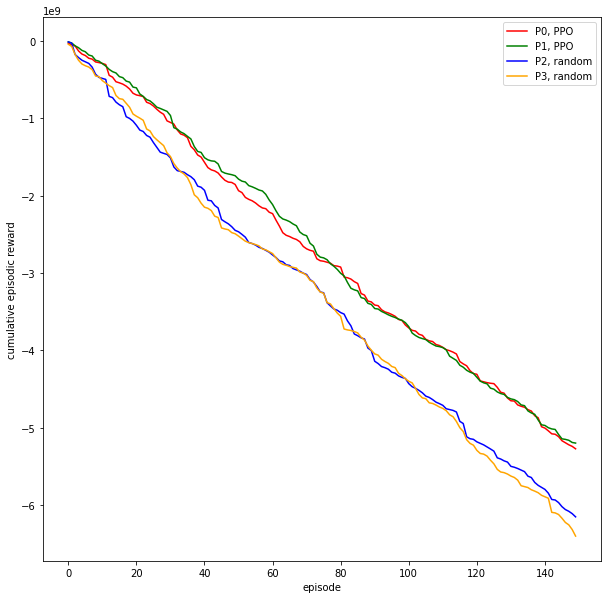

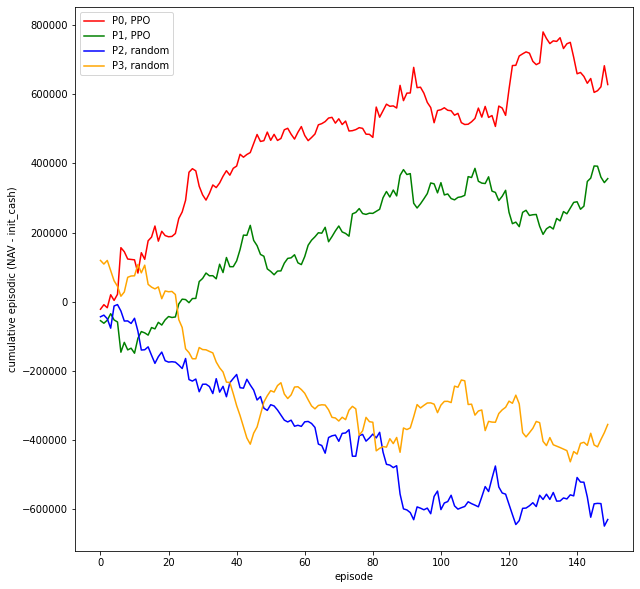

In [16]:
"""
Plot episodic results
"""

import matplotlib.pyplot as plt


def plot_result(x,p0,p1,p2,p3,x_msg,y_msg):

    plt.figure(figsize=(10,10))

    plt.xlabel(x_msg)
    plt.ylabel(y_msg)

    plt.plot(x, p0, 'r', label='P0, PPO') # plotting x, y
    plt.plot(x, p1, 'g', label='P1, PPO') 
    plt.plot(x, p2, 'b', label='P2, random') 
    plt.plot(x, p3, 'orange', label='P3, random') 

    plt.legend()
    plt.show()


x = range(num_iters)
plot_result(x,
            np.cumsum(reward_store["agt_0_reward_list"]),
            np.cumsum(reward_store["agt_1_reward_list"]),
            np.cumsum(reward_store["agt_2_reward_list"]),
            np.cumsum(reward_store["agt_3_reward_list"]),
            'episode','cumulative episodic reward')

list_0 = NAV_store["agt_0_NAV_list"]
list_1 = NAV_store["agt_1_NAV_list"]
list_2 = NAV_store["agt_2_NAV_list"]
list_3 = NAV_store["agt_3_NAV_list"]
plot_result(x,
            np.cumsum([value - init_cash for value in list_0]),
            np.cumsum([value - init_cash for value in list_1]),
            np.cumsum([value - init_cash for value in list_2]),
            np.cumsum([value - init_cash for value in list_3]),
            'episode','cumulative episodic (NAV - init_cash)')            